# Project 1
Hexi Meng UID:406300552
Zhanhong Liu UID:206152835

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import string
from sklearn.model_selection import train_test_split
import re
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk import pos_tag
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords, wordnet
from string import punctuation

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD,NMF
from scipy.sparse import random as sparse_random_matrix
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    mean_squared_error,
    precision_score,
    recall_score,
    roc_curve,
)

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
import requests
import zipfile
import io
from pathlib import Path


In [3]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/furymeng/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/furymeng/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/furymeng/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/furymeng/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/furymeng/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloadi

True

# Getting familiar with the dataset

In [4]:

# get row and columns of the CSV 
df = pd.read_csv('/Users/furymeng/Downloads/data.csv')
print(df.shape[0] , df.shape[1] )

3476 8


# question1
--There are 3476 rows and 8 columns in the datasheet

--Histogram: see below

--plots : see below


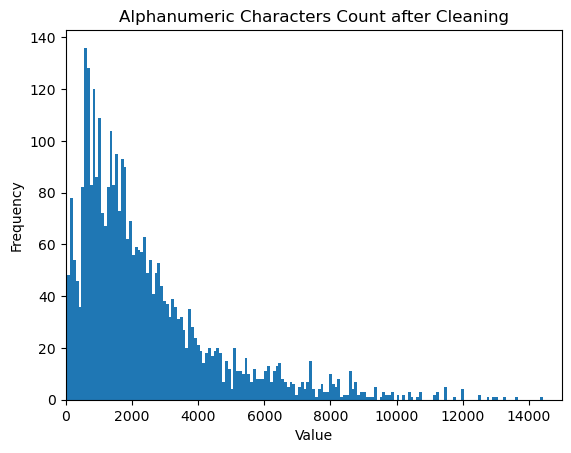

In [5]:

def clean_and_count_alnum(text):
    # Remove punctuation and special characters
    cleaned_text = text.translate(str.maketrans('', '', string.punctuation))
    # Count alphanumeric characters
    return sum(char.isalnum() for char in cleaned_text)

# Apply function to each row in the 'full_text' column
plot = df['full_text'].apply(clean_and_count_alnum)

# Plot the histogram
plt.hist(plot, bins=500)
plt.xlim([0, 15000])

plt.title('Alphanumeric Characters Count after Cleaning')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Interpretation of the plot

1.Most articles have no more than 8000 alpha-numeric characters,only few article have more than 10000 alpha-numeric characters

2.The distribution of alphanumeric character counts is right-skewed, as most of the data points are clustered on the left side of the histogram

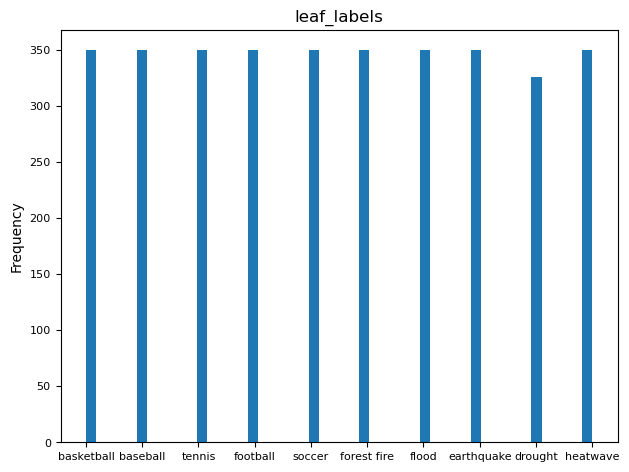

In [6]:
#read leaf_label column
leaf_label = df['leaf_label']
# Plot the histogram
plt.hist(leaf_label,bins=50)

plt.title('leaf_labels')
plt.ylabel('Frequency')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout(pad=1.0)
plt.show()

Interpretation of the plot

1.All the leaf label sports occurs about same amount time in the dataset,roughly 350 times ,except the drought


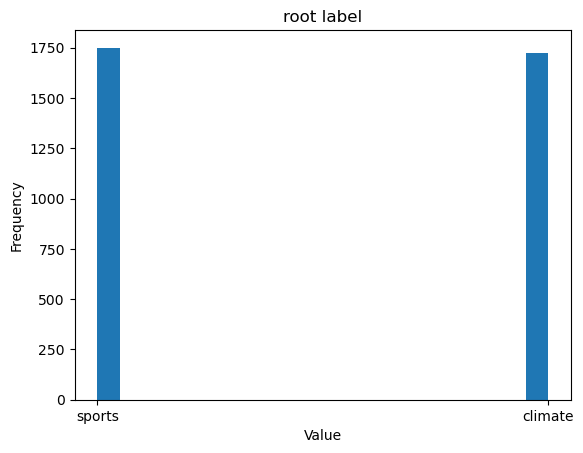

In [7]:
# read root_label column
root_label = df['root_label']
# Plot the histogram
plt.hist(root_label,bins=20)

plt.title('root label')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Interpretation of the plot

1.There are same number of articles related to sports as related to climate,both 1750 articles related to each of the two topic

# Binary Classification

In [8]:
#split data set into train and test arrays
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)
print('number of training samples :',train.shape[0])
print('number of test samples :',test.shape[0])

number of training samples : 2780
number of test samples : 696


# Question 2
number of training samples : 2780

number of test samples : 696

# Feature Extraction
 set up

In [9]:
wnl = nltk.wordnet.WordNetLemmatizer()

ps = nltk.stem.PorterStemmer()

stop_words_skt = text.ENGLISH_STOP_WORDS

stop_words_en = stopwords.words('english')

combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

In [10]:
# clean function
def clean(text):
 text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
 texter = re.sub(r"<br />", " ", text)
 texter = re.sub(r"&quot;", "\"",texter)
 texter = re.sub('&#39;', "\"", texter)
 texter = re.sub('\n', " ", texter)
 texter = re.sub(' u '," you ", texter)
 texter = re.sub('`',"", texter)
 texter = re.sub(' +', ' ', texter)
 texter = re.sub(r"(!)\1+", r"!", texter)
 texter = re.sub(r"(\?)\1+", r"?", texter)
 texter = re.sub('&amp;', 'and', texter)
 texter = re.sub('\r', ' ',texter)
 clean = re.compile('<.*?>')
 texter = texter.encode('ascii', 'ignore').decode('ascii')
 texter = re.sub(clean, '', texter)
 if texter == "":
   texter = ""
 return texter

def exclude_numbers(text):
    # This regular expression pattern matches integers, negative numbers, and floating-point numbers
    pattern = re.compile(r'-?\b\d+\.?\d*\b')
    
    # Replace all occurrences of the pattern with an empty string
    return pattern.sub("", text)

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word): 
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]



def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

def stemming(text):
    if isinstance(text, str):  # Check if input is a string
        ps = PorterStemmer()
        return ' '.join([ps.stem(word) for word in text.lower().split()])
    return text  

def lemmatize(text):
    if isinstance(text, str):  # Check if input is a string
        wnl = WordNetLemmatizer()
        return ' '.join([wnl.lemmatize(word) for word in text.lower().split()])
    return text 


In [11]:
train, test = train_test_split(df[['full_text', 'root_label']], test_size=0.2)
print(train.shape)
print(test.shape)

(2780, 2)
(696, 2)


In [12]:


train = train.applymap(clean)
test = test.applymap(clean)
wnl = nltk.wordnet.WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()
count_vect = CountVectorizer(min_df=3, stop_words='english',analyzer=stem_rmv_punc)
X_train = count_vect.fit_transform(train['full_text'])
X_test = count_vect.transform(test['full_text'])
print(X_train.shape)
print(X_test.shape)

/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


(2780, 13447)
(696, 13447)


In [13]:
tfidf_transformer = TfidfTransformer()

# recall that X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf = tfidf_transformer.fit_transform(X_test)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(2780, 13447)
(696, 13447)


# Question 3


### 1.
**Lemmatization**

Pros:

- **Precision**:Lemmatization has higer precision that results in more precise words since it involves a deep linguistic understanding, often using vocabularies and morphological analysis

- **Accuracy** :It converts the words into same meaningful base form

Cons:
- **Computationally heavy**:It requires more computational resources because it involves understanding the context and the grammatical rules of the language.

- **Language Dependency**:Highly dependent on the language's morphology and requires extensive language-specific resources.

**Steamming**

Pros:

- **Speed**:It is way faster than lemmatization since only use heuristic logistics to cuts off the end of words

- **Simplicity**: Easier to implement ,doesn't require knowledge about the language

Cons:

- **Lack of Accuracy**:It use simple heuristics so produces non actual words

### 2.

- Increase min_df will reduce the column number of the tfidf matrix since this reduces the overall size of the vocabulary,more words willbe filtered out.

### 3.
-  One should remove punctuation first as as they might be considered part of a word, leading to incorrect lemmatization, then lemmatize the text,then remove stopwotds to avoid missing lemmatization and finally remove the number.

###
- The size of the TF-IDF-processed train matrix is **2780 x 13635**

- The size of the TF-IDF-processed test matrix is **696 x 13635**


# Dimensionality Reduction

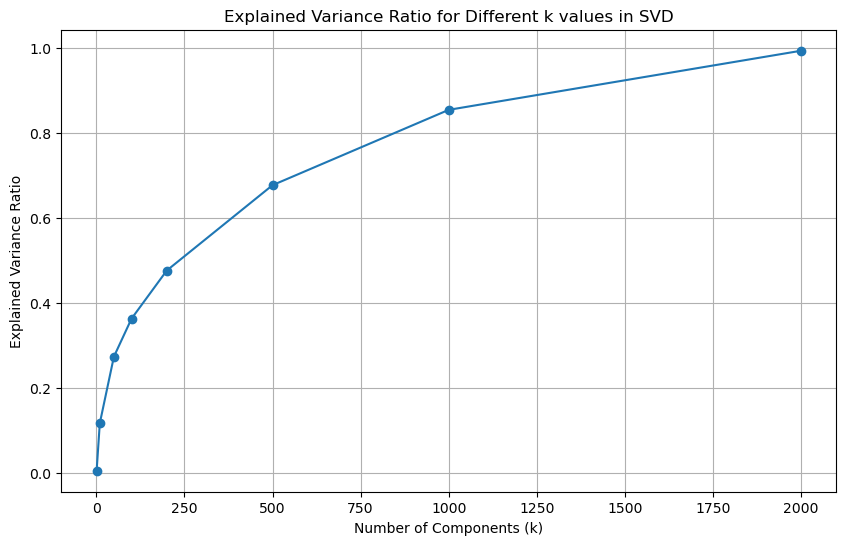

In [14]:
# k values to test
k_values = [1, 10, 50, 100, 200, 500, 1000, 2000]
explained_variance_ratios = []

for k in k_values:
    svd = TruncatedSVD(n_components=k)
    X_train_svd = svd.fit_transform(X_train_tfidf)
    X_test_svd = svd.transform(X_test_tfidf)

    explained_variance_ratios.append(svd.explained_variance_ratio_.sum())



# Plotting the explained variance ratio


plt.figure(figsize=(10, 6))
plt.plot(k_values, explained_variance_ratios, marker='o')
plt.title('Explained Variance Ratio for Different k values in SVD')
plt.xlabel('Number of Components (k)')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()



In [15]:
#LSI(SVD)
svd = TruncatedSVD(n_components=50)

X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)
X_lsi = svd.inverse_transform(X_train_svd)
#NMF
nmf = NMF(n_components=50, init='random', random_state=2)
W = nmf.fit_transform(X_train_tfidf)
H = nmf.components_
X_nmf = np.dot(W, H)

mse_lsi = mean_squared_error(X_train_tfidf.toarray(), X_lsi)
mse_nmf = mean_squared_error(X_train_tfidf.toarray(), X_nmf)

print("MSE for LSI:", mse_lsi)
print("MSE for NMF:", mse_nmf)



/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


MSE for LSI: 5.221120137248087e-05
MSE for NMF: 5.293630859956141e-05


# Question 4

- The graph looks like a log exponential curve,increase rapidly then converging,concavity suggesting that as K increases explained variance ration saturated 

- LSI has smaller MSE than NMF , because LSI, via SVD, captures the best lower-rank approximation in the least-squares sense. NMF, on the other hand, imposes non-negativity constraints which may lead to a less optimal fit in terms of least squares.

# Classification Algorithms

In [16]:
# Assuming 'train' and 'test' are your DataFrame containing the training and testing data
X_train_label = train["root_label"].copy()
X_test_label = test["root_label"].copy()

# Convert categorical label to 0 and 1
X_train_label = X_train_label.replace({'sports': 1, 'climate': 0}).astype(int)
X_test_label = X_test_label.replace({'sports': 1, 'climate': 0}).astype(int)



svm_1000 = SVC(C=1000, kernel='linear', probability=True)
svm_00001 = SVC(C=0.0001, kernel='linear', probability=True)


pipeline_hard_margin = Pipeline([('reduce_dim', TruncatedSVD(n_components=50)),('svm', svm_1000),])
pipeline_soft_margin = Pipeline([('reduce_dim', TruncatedSVD(n_components=50)),('svm', svm_00001),])


In [17]:
#roc plot function
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)
    # pipeline1.predict(twenty_test.data)

    if hasattr(pipe, 'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr)
    return pipe

Confusion matrix is:
 [[325  30]
 [ 26 315]]
Accuracy:  0.9195402298850575
Recall:  0.9237536656891495
Precision:  0.9130434782608695
F-1 score:  0.9183673469387754


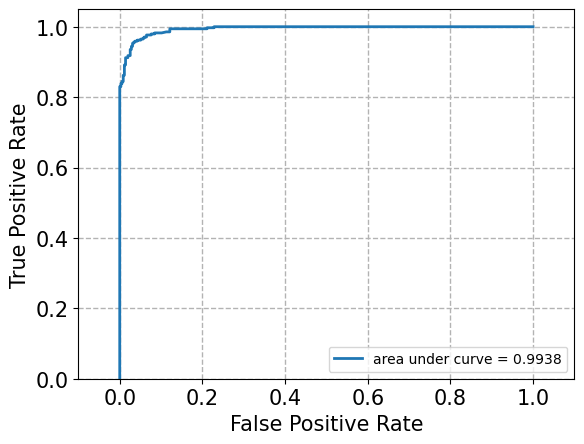

In [18]:


# gamma = 1000
fit_predict_and_plot_roc(pipeline_hard_margin, X_train_tfidf, X_train_label, X_test_tfidf, X_test_label)


predictions = svm_1000.predict(X_test_svd)

# output
confusion_matrix = metrics.confusion_matrix(X_test_label, predictions)
accuracy = metrics.accuracy_score(X_test_label, predictions)
recall = metrics.recall_score(X_test_label, predictions)
precision = metrics.precision_score(X_test_label, predictions)
f1 = metrics.f1_score(X_test_label, predictions)

# Output results
print("Confusion matrix is:\n", confusion_matrix)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("F-1 score: ", f1)


Confusion matrix is:
 [[  0 355]
 [  0 341]]
Accuracy:  0.4899425287356322
Recall:  1.0
Precision:  0.4899425287356322
F-1 score:  0.6576663452266153


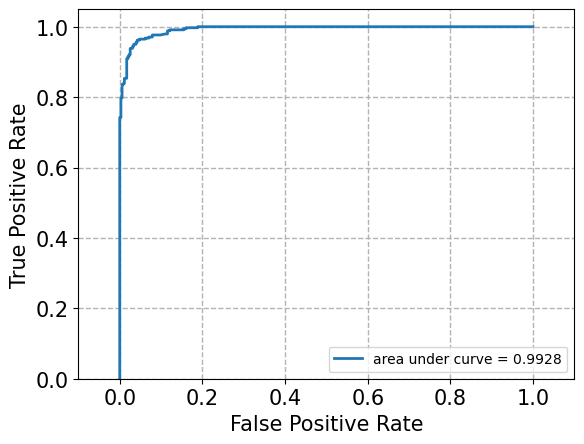

In [19]:
# gamma = 0.0001
fit_predict_and_plot_roc(pipeline_hard_margin, X_train_tfidf, X_train_label, X_test_tfidf, X_test_label)

svm_00001.fit(X_train_svd, X_train_label)
predictions = svm_00001.predict(X_test_svd)

# output
confusion_matrix = metrics.confusion_matrix(X_test_label, predictions)
accuracy = metrics.accuracy_score(X_test_label, predictions)
recall = metrics.recall_score(X_test_label, predictions)
precision = metrics.precision_score(X_test_label, predictions)
f1 = metrics.f1_score(X_test_label, predictions)

# Output results
print("Confusion matrix is:\n", confusion_matrix)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("F-1 score: ", f1)

Confusion matrix is:
 [[339  16]
 [ 16 325]]
Accuracy:  0.9540229885057471
Recall:  0.9530791788856305
Precision:  0.9530791788856305
F-1 score:  0.9530791788856305


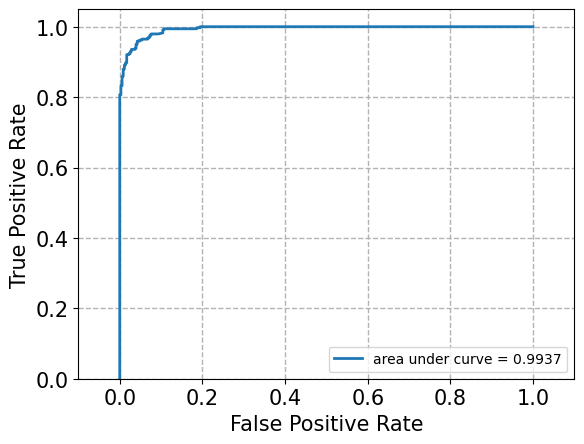

In [20]:

# gamma = 100000
svm_100000 = SVC(C=100000, kernel='linear', probability=True)
pipeline_gamma_100000 = Pipeline([('reduce_dim', TruncatedSVD(n_components=50)),('svm', svm_100000),])

# Use the correct pipeline for gamma=100000
fit_predict_and_plot_roc(pipeline_gamma_100000, X_train_tfidf, X_train_label, X_test_tfidf, X_test_label)

svm_100000.fit(X_train_svd, X_train_label)

# Predict using svm_100000
predictions = svm_100000.predict(X_test_svd)

# output
confusion_matrix = metrics.confusion_matrix(X_test_label, predictions)
accuracy = metrics.accuracy_score(X_test_label, predictions)
recall = metrics.recall_score(X_test_label, predictions)
precision = metrics.precision_score(X_test_label, predictions)
f1 = metrics.f1_score(X_test_label, predictions)

# Output results
print("Confusion matrix is:\n", confusion_matrix)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("F-1 score: ", f1)




In [21]:
c=[10**-3, 10**-2, 10**-1, 10, 100, 1000, 10000, 100000, 100000]


validation_accuracy=[]

for i in c:
  svm_opt = SVC(C=i)
  scores = cross_val_score(svm_opt, X_train_svd, X_train_label, cv=5)
  scores = scores.mean()
  validation_accuracy.append(scores)

print(validation_accuracy)
max_accuracy = max(validation_accuracy)
max_index = validation_accuracy.index(max_accuracy)
optimal_c = c[max_index]

print("Optimal C value:", optimal_c)
print("Maximum accuracy:", max_accuracy)


[0.5068345323741006, 0.8870503597122303, 0.9510791366906475, 0.9651079136690648, 0.966546762589928, 0.9593525179856115, 0.9593525179856115, 0.9593525179856115, 0.9593525179856115]
Optimal C value: 100
Maximum accuracy: 0.966546762589928


Confusion matrix is:
 [[337  18]
 [ 11 330]]
Accuracy:  0.9583333333333334
Recall:  0.967741935483871
Precision:  0.9482758620689655
F-1 score:  0.9579100145137881


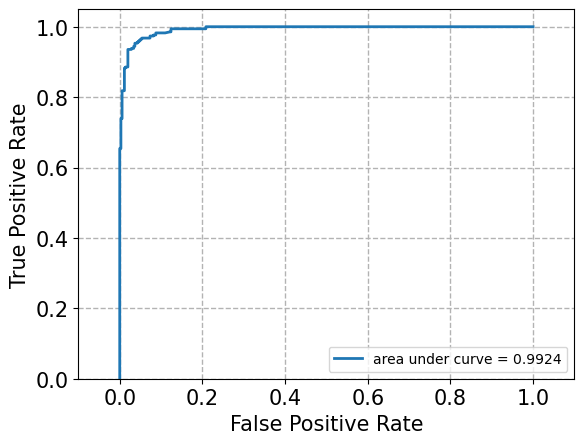

In [22]:
# optimal gamma = 100

svm_100 = SVC(C=100, kernel='linear', probability=True)
pipeline_gamma_100 = Pipeline([('reduce_dim', TruncatedSVD(n_components=50)),('svm', svm_100),])

fit_predict_and_plot_roc(pipeline_hard_margin, X_train_tfidf, X_train_label, X_test_tfidf, X_test_label)

svm_100.fit(X_train_svd, X_train_label)

predictions = svm_100.predict(X_test_svd)

# output
confusion_matrix = metrics.confusion_matrix(X_test_label, predictions)
accuracy = metrics.accuracy_score(X_test_label, predictions)
recall = metrics.recall_score(X_test_label, predictions)
precision = metrics.precision_score(X_test_label, predictions)
f_1 = metrics.f1_score(X_test_label, predictions)

# Output results
print("Confusion matrix is:\n", confusion_matrix)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("F-1 score: ", f_1)


# Question 5

####
- See results above

- See output graph above

- hard margin performs better, for γ = 100000 , the accuracy decreases possibily due to training data overfitting

- 

- best value of γ = 100

  Confusion matrix is:
   
       [[340  17]
  
        [12 327]]

   Accuracy:  0.9583333333333334

   Recall:  0.9646017699115044

   Precision:  0.9505813953488372

   F-1 score:  0.9575402635431918


# Logistic regression



/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Confusion matrix is:
 [[344  11]
 [ 10 331]]
Accuracy is: 0.9698275862068966
Recall is: 0.9706744868035191
Precision is: 0.9678362573099415
F1 score is: 0.9692532942898975


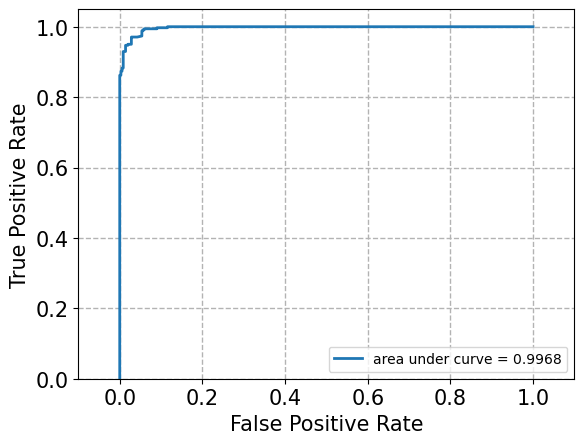

In [23]:
pipeline_log = LogisticRegression(penalty="none", max_iter=1000000)

# Fit and plot ROC curve using the pipeline
fit_predict_and_plot_roc(pipeline_log, X_train_tfidf, X_train_label, X_test_tfidf, X_test_label)

# Make predictions using the pipeline
pipeline_log.fit(X_train_tfidf, X_train_label)
predictions = pipeline_log.predict(X_test_tfidf)

#output
confusion_matrix = metrics.confusion_matrix(X_test_label, predictions)
accuracy = metrics.accuracy_score(X_test_label, predictions)
recall = metrics.recall_score(X_test_label, predictions)
precision = metrics.precision_score(X_test_label, predictions)
f1 = metrics.f1_score(X_test_label, predictions)

# Output results
print("Confusion matrix is:\n", confusion_matrix)
print("Accuracy is:", accuracy)
print("Recall is:", recall)
print("Precision is:", precision)
print("F1 score is:", f1)


In [24]:
pipe_l1 = Pipeline([
    ('reduce_dim', TruncatedSVD(n_components=50)),
    ('log_reg', LogisticRegression(penalty='l1', solver='liblinear'))
])

pipe_l2 = Pipeline([
    ('reduce_dim', TruncatedSVD(n_components=50)),
    ('log_reg', LogisticRegression(penalty='l2'))
])

# Define the parameter grid
param_grid = {'log_reg__C': np.logspace(-5, 5, 11)}

# Grid search with 5-fold cross-validation
grid_search_l1 = GridSearchCV(pipe_l1, param_grid, cv=5, scoring='accuracy')
grid_search_l2 = GridSearchCV(pipe_l2, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search_l1.fit(X_train_svd, X_train_label)
grid_search_l2.fit(X_train_svd, X_train_label)

# Best parameters 
print("Best parameters (L1):", grid_search_l1.best_params_)
print("Best parameters (L2):", grid_search_l2.best_params_)

/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Best parameters (L1): {'log_reg__C': 100.0}
Best parameters (L2): {'log_reg__C': 10000.0}


/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

In [25]:

# Create logistic regression models
log_reg_0 = LogisticRegression(penalty="none", max_iter=100000)
log_reg_l1 = LogisticRegression(penalty="l1", C=10, solver='liblinear', max_iter=100000)
log_reg_l2 = LogisticRegression(penalty="l2", C=100, max_iter=100000)

# Fit the models
log_reg_0.fit(X_train_svd, X_train_label)
log_reg_l1.fit(X_train_svd, X_train_label)
log_reg_l2.fit(X_train_svd, X_train_label)

# Evaluate each model
models = {
    "No Regularization": log_reg_0,
    "L1 Regularization": log_reg_l1,
    "L2 Regularization": log_reg_l2
}

for name, model in models.items():
    predictions = model.predict(X_test_svd)
    accuracy = accuracy_score(X_test_label, predictions)
    precision = precision_score(X_test_label, predictions)
    recall = recall_score(X_test_label, predictions)
    f1 = f1_score(X_test_label, predictions)

    print(f"Results for {name}:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("\n")

/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Results for No Regularization:
Accuracy: 0.9554597701149425
Precision: 0.9532163742690059
Recall: 0.9560117302052786
F1 Score: 0.9546120058565154


Results for L1 Regularization:
Accuracy: 0.9568965517241379
Precision: 0.9533527696793003
Recall: 0.9589442815249267
F1 Score: 0.956140350877193


Results for L2 Regularization:
Accuracy: 0.9583333333333334
Precision: 0.9534883720930233
Recall: 0.9618768328445748
F1 Score: 0.9576642335766424




# Quesion6
- Best parameters (L1): 10.0
  
  Best parameters (L2): 100.0

- See output above for performance regarding w/o regularization, w/ L1 regularization and w/ L2 regularization 

- Higher regulating parameters reduces testing error, however, if 'C' is too high, the model may start overfitting, and the test error could increase.**L1** can shrink some coefficients to zero, effectively removing those features from the model and make the model simpler therefore it is preferred when we need a sparse model with fewer features whereas **L2** does not result in feature elimination. It can be preferred when all features are expected to contribute,also decreasing the model complexity and  increase the stability of the model

- Logistic Regression vs SVM:
Logistic regression derive the decision boundary based on the probability estimates(minimum loglikelyhood), linear SVM's decision boundary is determined by the support vectors and the margin,
As a result SVMs can perform better when there's a clear margin of separation in the data, whereas logistic regression can be more robust to overlapping class distributions.Therefore their performance really depend on the types of dataset,if the dataset is large, logistic regression might be more suitable, whereas if the set is high-dimensional data where a clear margin is present, an SVM might offer better performance.




# Naive Bayes Model

Confusion matrix is:
 [[299  56]
 [ 13 328]]
Accuracy is: 0.9008620689655172
Recall is: 0.9618768328445748
Precision is: 0.8541666666666666
F1 score is: 0.9048275862068966


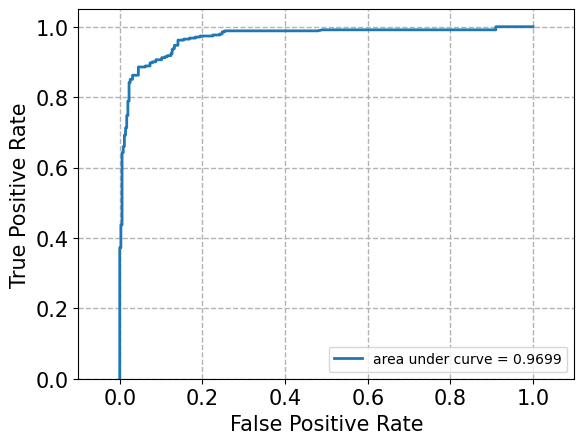

In [26]:
# Create and train Gaussian Naive Bayes classifier
gnb = GaussianNB()
pipeline_gnb = Pipeline([('reduce_dim', TruncatedSVD(n_components=50)),('gnb', gnb)])

gnb.fit(X_train_svd, X_train_label)

# Predictions and Evaluation
predictions = gnb.predict(X_test_svd)
#roc curve
fit_predict_and_plot_roc(pipeline_gnb, X_train_tfidf, X_train_label, X_test_tfidf, X_test_label)
#output
confusion_matrix = metrics.confusion_matrix(X_test_label, predictions)
accuracy = metrics.accuracy_score(X_test_label, predictions)
recall = metrics.recall_score(X_test_label, predictions)
precision = metrics.precision_score(X_test_label, predictions)
f1 = metrics.f1_score(X_test_label, predictions)

# Output results
print("Confusion matrix is:\n", confusion_matrix)
print("Accuracy is:", accuracy)
print("Recall is:", recall)
print("Precision is:", precision)
print("F1 score is:", f1)

# Question 7
- See results above for GaussianNB classifier

# Grid Search of Parameters

In [27]:
ps = nltk.stem.PorterStemmer()
wnl = nltk.wordnet.WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()
train_stemmed = stemming(train['full_text'])
train_lemmatized = lemmatize(train['full_text'])

# test_cleaned = test.applymap(clean)
test_stemmed = stemming(test['full_text'])
test_lemmatized = lemmatize(test['full_text'])

count_vect = CountVectorizer(min_df=3, stop_words='english',analyzer=stem_rmv_punc)

svd = TruncatedSVD(n_iter=7)
nmf = NMF(init='random', max_iter=500)
svm = SVC(C=10, kernel='linear', probability=True)

log_l1 = LogisticRegression(penalty="l1", C=10, solver='liblinear', max_iter=100000)
log_l2 = LogisticRegression(penalty="l2", C=100, max_iter=100000)
gau = GaussianNB()


cachedir = mkdtemp()

#pipeline set up
pipeline = Pipeline(steps=[
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("reduce_dim", None),  
    ("classifier", None)  
], memory=cachedir)

parameters = {
    "vect__min_df": [3, 5],
    "reduce_dim": [svd, nmf],
    "reduce_dim__n_components": [5, 30, 80],
    "classifier": [svm, log_l1, log_l2, gau]
}

grid_lemmatized = GridSearchCV(pipeline, param_grid=parameters, n_jobs=4, cv=5, scoring='accuracy')
grid_lemmatized.fit(train_lemmatized, X_train_label)

# Set up GridSearchCV for stemmed data
grid_stemmed = GridSearchCV(pipeline, param_grid=parameters, n_jobs=4, cv=5, scoring='accuracy')
grid_stemmed.fit(train_stemmed, X_train_label)

# Clean up the cache directory
rmtree(cachedir)

parameters = {
    "vect__min_df": [3, 5],
    "reduce_dim": [svd, nmf],
    "reduce_dim__n_components": [5, 30, 80],
    "classifier": [SVC(C=10, kernel='linear', probability=True), LogisticRegression(penalty='l1'), LogisticRegression(penalty='l2'), GaussianNB()]
}

/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


In [28]:
cachedir = mkdtemp()
# Run grid search on lemmatized data
grid_lemmatized = GridSearchCV(pipeline, param_grid=parameters, n_jobs=4, cv=5, scoring='accuracy')
grid_lemmatized.fit(train_lemmatized, X_train_label)

# Run grid search on stemmed data
grid_stemmed = GridSearchCV(pipeline, param_grid=parameters, n_jobs=4, cv=5, scoring='accuracy')
grid_stemmed.fit(train_stemmed, X_train_label)

# Clean up the cache directory
rmtree(cachedir)

print("Best parameters for lemmatized data:", grid_lemmatized.best_params_)
print("Best score for lemmatized data:", grid_lemmatized.best_score_)

print("Best parameters for stemmed data:", grid_stemmed.best_params_)
print("Best score for stemmed data:", grid_stemmed.best_score_)


/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/furymeng/anaconda3/lib/python3.11/site-p

Best parameters for lemmatized data: {'classifier': SVC(C=10, kernel='linear', probability=True), 'reduce_dim': TruncatedSVD(n_components=80, n_iter=7), 'reduce_dim__n_components': 80, 'vect__min_df': 5}
Best score for lemmatized data: 0.960431654676259
Best parameters for stemmed data: {'classifier': SVC(C=10, kernel='linear', probability=True), 'reduce_dim': TruncatedSVD(n_components=80, n_iter=7), 'reduce_dim__n_components': 80, 'vect__min_df': 5}
Best score for stemmed data: 0.960431654676259


In [29]:


# Convert the grid search results to pandas DataFrames
results_stemmed = pd.DataFrame(grid_stemmed.cv_results_)
results_lemmatized = pd.DataFrame(grid_lemmatized.cv_results_)

results_stemmed['Compression'] = 'Stemming'
results_lemmatized['Compression'] = 'Lemmatization'

# Combine the results 
combined_results = pd.concat([results_stemmed, results_lemmatized])

# sort the results
ordered_results = combined_results.sort_values('rank_test_score')

# Display the top 5 configurations
top_configurations = ordered_results.head(5)
for index, row in top_configurations.iterrows():
    rank = row['rank_test_score']
    method = row['Compression']
    parameters = row['params']
    print(f"Rank: {rank}, Method: {method}, Parameters: {parameters}")


Rank: 1, Method: Stemming, Parameters: {'classifier': SVC(C=10, kernel='linear', probability=True), 'reduce_dim': TruncatedSVD(n_components=80, n_iter=7), 'reduce_dim__n_components': 80, 'vect__min_df': 5}
Rank: 1, Method: Lemmatization, Parameters: {'classifier': SVC(C=10, kernel='linear', probability=True), 'reduce_dim': TruncatedSVD(n_components=80, n_iter=7), 'reduce_dim__n_components': 80, 'vect__min_df': 5}
Rank: 2, Method: Stemming, Parameters: {'classifier': SVC(C=10, kernel='linear', probability=True), 'reduce_dim': TruncatedSVD(n_components=80, n_iter=7), 'reduce_dim__n_components': 80, 'vect__min_df': 3}
Rank: 2, Method: Lemmatization, Parameters: {'classifier': SVC(C=10, kernel='linear', probability=True), 'reduce_dim': TruncatedSVD(n_components=80, n_iter=7), 'reduce_dim__n_components': 80, 'vect__min_df': 3}
Rank: 3, Method: Lemmatization, Parameters: {'classifier': LogisticRegression(), 'reduce_dim': TruncatedSVD(n_components=80, n_iter=7), 'reduce_dim__n_components': 80

In [30]:

data_configs = [
    # Configurations with GaussianNB
    {"data": "stemmed", "min_df": 3, "reduce_dim": TruncatedSVD(n_components=5, n_iter=7, random_state=42), "classifier": GaussianNB()},
    {"data": "lemmatized", "min_df": 3, "reduce_dim": TruncatedSVD(n_components=5, n_iter=7, random_state=42), "classifier": GaussianNB()},
    {"data": "lemmatized", "min_df": 5, "reduce_dim": NMF(init='random', n_components=5, max_iter=300, random_state=42), "classifier": GaussianNB()},

    # Configurations with Logistic Regression
    {"data": "stemmed", "min_df": 5, "reduce_dim": TruncatedSVD(n_components=5, n_iter=7, random_state=42), "classifier": LogisticRegression()},
    {"data": "lemmatized", "min_df": 5, "reduce_dim": TruncatedSVD(n_components=5, n_iter=7, random_state=42), "classifier": LogisticRegression()}
]

pipelines = []

for config in data_configs:
    if config["data"] == "stemmed":
        train_data = train_stemmed
        test_data = test_stemmed
    else:
        train_data = train_lemmatized
        test_data = test_lemmatized

    pipeline = Pipeline(steps=[
        ("vect", CountVectorizer(min_df=config["min_df"], stop_words='english', analyzer='word')),
        ("tfidf", TfidfTransformer()),
        ("reduce_dim", config["reduce_dim"]),
        ("classifier", config["classifier"])
    ])

    pipelines.append({"train": train_data, "test": test_data, "pipeline": pipeline})





In [31]:
performance_data = []

for pipeline_dict in pipelines:


    # Fit the pipeline to the training data
    pipeline_dict["pipeline"].fit(pipeline_dict["train"], X_train_label)

    # Predict on the test data
    predictions = pipeline_dict["pipeline"].predict(pipeline_dict["test"])

    # Calculate performance metrics
    accuracy = accuracy_score(X_test_label, predictions)
    precision = precision_score(X_test_label, predictions)
    recall = recall_score(X_test_label, predictions)
    f1 = f1_score(X_test_label, predictions)

    # Append performance metrics and preprocessing method to the list
    performance_data.append({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })


In [32]:
formatted_results = []

for pipeline_dict, performance in zip(pipelines, performance_data):
    # Extracting configuration details
    min_df = pipeline_dict['pipeline'].named_steps['vect'].min_df
    n_components = pipeline_dict['pipeline'].named_steps['reduce_dim'].n_components
    classifier_name = type(pipeline_dict['pipeline'].named_steps['classifier']).__name__

    # Combining configuration details with performance metrics
    formatted_results.append({
        "min_df": min_df,
        "k (n_components)": n_components,
        "Classifier": classifier_name,
        "Accuracy": performance['Accuracy'],
        "Precision": performance['Precision'],
        "Recall": performance['Recall'],
        "F1 Score": performance['F1 Score']
    })

results_df = pd.DataFrame(formatted_results)
top_5_results_df = results_df.sort_values(by='Accuracy', ascending=False).head(5)
print("Top 5 Pipeline Configurations Based on Accuracy:")
print(top_5_results_df.to_string(index=False))



Top 5 Pipeline Configurations Based on Accuracy:
 min_df  k (n_components)         Classifier  Accuracy  Precision   Recall  F1 Score
      5                 5 LogisticRegression  0.913793   0.874667 0.961877  0.916201
      5                 5 LogisticRegression  0.913793   0.874667 0.961877  0.916201
      5                 5         GaussianNB  0.906609   0.867021 0.956012  0.909344
      3                 5         GaussianNB  0.875000   0.796729 1.000000  0.886866
      3                 5         GaussianNB  0.875000   0.796729 1.000000  0.886866


# Question 8
- see result performance data above

# Multiclass Clasification

In [33]:



train_data, test_data = train_test_split(df[['full_text', 'leaf_label']], test_size=0.2)
train_data['full_text'] = train_data['full_text'].apply(clean)
test_data['full_text'] = test_data['full_text'].apply(clean)
# Encoding the labels for the classification task
encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_data['leaf_label'])
test_labels = encoder.transform(test_data['leaf_label'])


# Constructing a pipeline for text processing and dimensionality reduction
text_pipeline = Pipeline([
    ('count_vect', CountVectorizer(stop_words='english', min_df=3)),
    ('tfidf_transform', TfidfTransformer()),
    ('dimension_reduction', TruncatedSVD(n_components=50, random_state=42))
])

# Applying the pipeline to both training and testing text data
processed_train = text_pipeline.fit_transform(train_data['full_text'])
processed_test = text_pipeline.transform(test_data['full_text'])


In [36]:
#Naive Bayes Classification
gnb = GaussianNB()

# Train the classifier
gnb.fit(processed_train, train_labels)

# Make predictions
predictions_gnb = gnb.predict(processed_test)

# Calculate metrics for Naive Bayes
conf_matrix_gnb = confusion_matrix(test_labels, predictions_gnb)
accuracy_gnb = accuracy_score(test_labels, predictions_gnb)
recall_gnb = recall_score(test_labels, predictions_gnb, average='macro')
precision_gnb = precision_score(test_labels, predictions_gnb, average='macro')
f1_gnb = f1_score(test_labels, predictions_gnb, average='macro')

In [37]:
# finding the most confused labels

num_classes = conf_matrix_gnb.shape[0]
most_confused_pairs = []

for i in range(num_classes):
    for j in range(num_classes):
        if i != j and conf_matrix_gnb[i, j] > 5: 
            most_confused_pairs.append((i, j, conf_matrix_gnb[i, j]))

# Sorting the pairs by confusion frequency
most_confused_pairs.sort(key=lambda x: x[2], reverse=True)

# Printing the most confused pairs
for pair in most_confused_pairs:
    print(f"Classes {pair[0]} and {pair[1]} are confused {pair[2]} times")

Classes 7 and 6 are confused 36 times
Classes 0 and 9 are confused 17 times
Classes 7 and 9 are confused 14 times
Classes 6 and 7 are confused 10 times
Classes 6 and 4 are confused 9 times
Classes 5 and 8 are confused 8 times
Classes 6 and 8 are confused 7 times
Classes 8 and 9 are confused 7 times
Classes 1 and 9 are confused 6 times
Classes 3 and 9 are confused 6 times
Classes 6 and 2 are confused 6 times
Classes 6 and 9 are confused 6 times
Classes 9 and 0 are confused 6 times


In [38]:
#One-VS-One 
svm_classifier = SVC()

# Wrap the classifier with OneVsOneClassifier
svm_ovo = OneVsOneClassifier(svm_classifier)

# Train the classifier
svm_ovo.fit(processed_train, train_labels)

# Make predictions
predictions_svm_ovo = svm_ovo.predict(processed_test)

# Calculate metrics for One-VS-One SVM
conf_matrix_svm_ovo = confusion_matrix(test_labels, predictions_svm_ovo)
accuracy_svm_ovo = accuracy_score(test_labels, predictions_svm_ovo)
recall_svm_ovo = recall_score(test_labels, predictions_svm_ovo, average='macro')
precision_svm_ovo = precision_score(test_labels, predictions_svm_ovo, average='macro')
f1_svm_ovo = f1_score(test_labels, predictions_svm_ovo, average='macro')



In [39]:
# function for merging labels
def merge_labels(labels, label_to_merge, new_label_value):
    return np.where(labels == label_to_merge, new_label_value, labels)

In [40]:
# One-VS-One SVM with merged labels
train_labels_merged = merge_labels(train_labels, 6, 7)
test_labels_merged = merge_labels(test_labels, 6, 7)

svm_ovo.fit(processed_train, train_labels_merged)
predictions_svm_ovo_merged = svm_ovo.predict(processed_test)

conf_matrix_svm_ovo_merged = confusion_matrix(test_labels_merged, predictions_svm_ovo_merged)
accuracy_svm_ovo_merged = accuracy_score(test_labels_merged, predictions_svm_ovo_merged)
recall_svm_ovo_merged = recall_score(test_labels, predictions_svm_ovo, average='macro')
precision_svm_ovo_merged = precision_score(test_labels, predictions_svm_ovo, average='macro')
f1_svm_ovo_merged = f1_score(test_labels, predictions_svm_ovo, average='macro')

In [41]:
#balanced One-VS-One 
svm_ovo_balanced = SVC(decision_function_shape='ovo', class_weight='balanced')

# Train the classifier
svm_ovo_balanced.fit(processed_train, train_labels_merged)

# Make predictions
predictions_svm_ovo_balanced = svm_ovo_balanced.predict(processed_test)

# Calculate metrics for One-VS-Rest SVM with balanced class weights
conf_matrix_svm_ovo_balanced = confusion_matrix(test_labels, predictions_svm_ovo_balanced)
accuracy_svm_ovo_balanced = accuracy_score(test_labels, predictions_svm_ovo_balanced)
recall_svm_ovo_balanced = recall_score(test_labels, predictions_svm_ovo_balanced, average='macro')
precision_svm_ovo_balanced = precision_score(test_labels, predictions_svm_ovo_balanced, average='macro')
f1_svm_ovo_balanced = f1_score(test_labels, predictions_svm_ovo_balanced, average='macro')

/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
#One-vs-Rest
svm_classifier = SVC()

# Wrap the classifier with OneVsRestClassifier
svm_ovr = OneVsRestClassifier(svm_classifier)

# Train the classifier
svm_ovr.fit(processed_train, train_labels)

# Make predictions
predictions_svm_ovr = svm_ovr.predict(processed_test)

# Calculate metrics for One-VS-Rest SVM
conf_matrix_svm_ovr = confusion_matrix(test_labels, predictions_svm_ovr)
accuracy_svm_ovr = accuracy_score(test_labels, predictions_svm_ovr)
recall_svm_ovr = recall_score(test_labels, predictions_svm_ovr, average='macro')
precision_svm_ovr = precision_score(test_labels, predictions_svm_ovr, average='macro')
f1_svm_ovr = f1_score(test_labels, predictions_svm_ovr, average='macro')


In [43]:
#One-VS-Rest with merged labels
svm_ovr.fit(processed_train, train_labels_merged)
predictions_svm_ovr_merged = svm_ovo.predict(processed_test)

conf_matrix_svm_ovr_merged = confusion_matrix(test_labels_merged, predictions_svm_ovr_merged)
accuracy_svm_ovr_merged = accuracy_score(test_labels_merged, predictions_svm_ovr_merged)
recall_svm_ovr_merged = recall_score(test_labels, predictions_svm_ovr, average='macro')
precision_svm_ovr_merged = precision_score(test_labels, predictions_svm_ovr, average='macro')
f1_svm_ovr_merged = f1_score(test_labels, predictions_svm_ovr, average='macro')

In [44]:

#balanced One-VS-Rest strategy
svm_ovr_balanced = SVC(decision_function_shape='ovr', class_weight='balanced')

# Train the classifier
svm_ovr_balanced.fit(processed_train, train_labels_merged)

# Make predictions
predictions_svm_ovr_balanced = svm_ovr_balanced.predict(processed_test)

# Calculate metrics for One-VS-Rest SVM with balanced class weights
conf_matrix_svm_ovr_balanced = confusion_matrix(test_labels, predictions_svm_ovr_balanced)
accuracy_svm_ovr_balanced = accuracy_score(test_labels, predictions_svm_ovr_balanced)
recall_svm_ovr_balanced = recall_score(test_labels, predictions_svm_ovr_balanced, average='macro')
precision_svm_ovr_balanced = precision_score(test_labels, predictions_svm_ovr_balanced, average='macro')
f1_svm_ovr_balanced = f1_score(test_labels, predictions_svm_ovr_balanced, average='macro')




/Users/furymeng/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Naive Bayes Classifier:


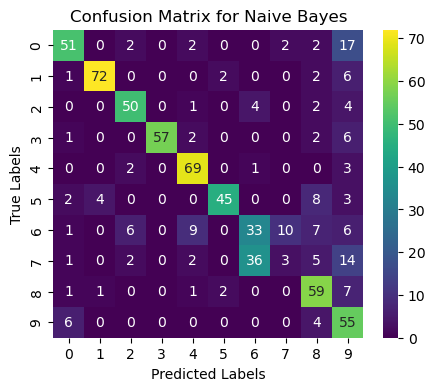

Accuracy: 0.7097701149425287
Recall: 0.7025328530574296
Precision: 0.7007927525145334
F1 Score: 0.6870304009240783


One-VS-One SVM Classifier:


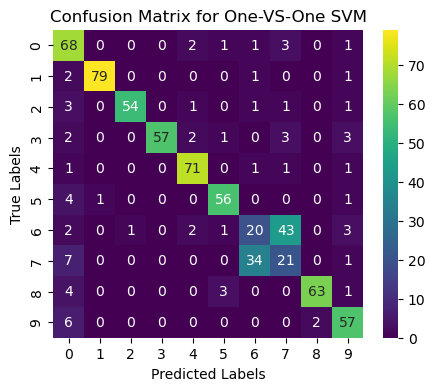

Accuracy: 0.7844827586206896
Recall: 0.7795275871592358
Precision: 0.7889679821784938
F1 Score: 0.7810551326373879


One-VS-One SVM Classifier (Merged):


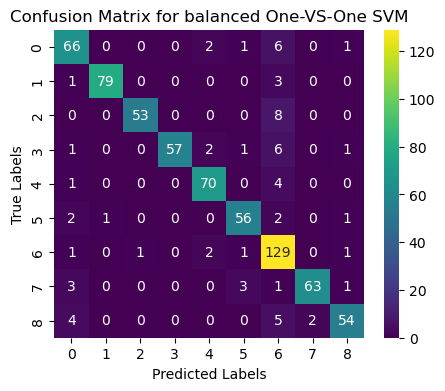

Accuracy: 0.9008620689655172
Recall: 0.7795275871592358
Precision: 0.7889679821784938
F1 Score: 0.7810551326373879


One-VS-One SVM Classifier (Balanced):


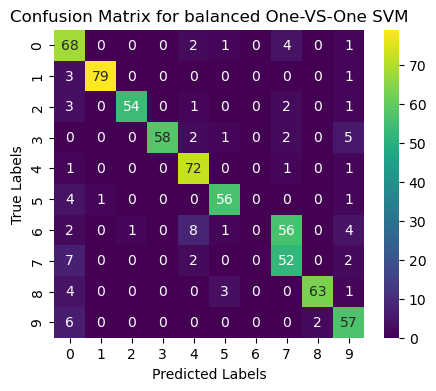

Accuracy: 0.8031609195402298
Recall: 0.8037600801564345
Precision: 0.7577953230132239
F1 Score: 0.7719110698415734


One-VS-Rest SVM Classifier:


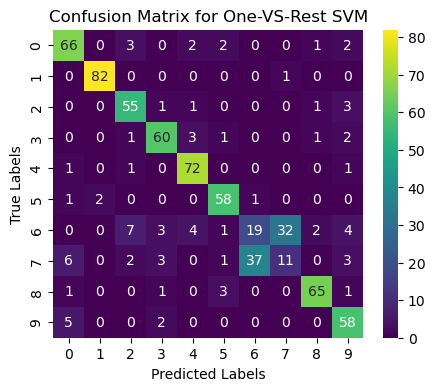

Accuracy: 0.7844827586206896
Recall: 0.7782141729813238
Precision: 0.7507959987572924
F1 Score: 0.7624055599821932


One-VS-Rest SVM Classifier(merged):


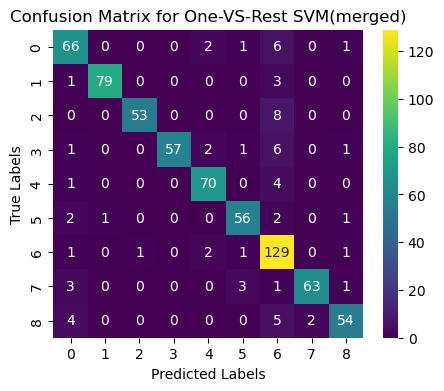

Accuracy: 0.9008620689655172
Recall: 0.7782141729813238
Precision: 0.7507959987572924
F1 Score: 0.7624055599821932


One-VS-Rest SVM Classifier (Balanced):


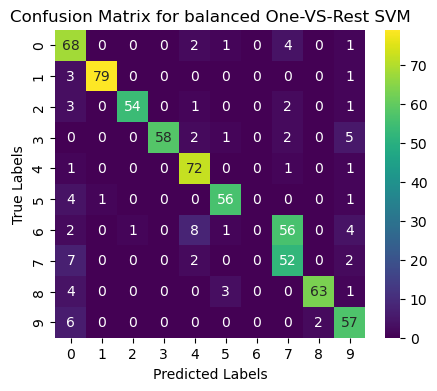

Accuracy: 0.8031609195402298
Recall: 0.8037600801564345
Precision: 0.7577953230132239
F1 Score: 0.7719110698415734


In [45]:
# Print the results for Naive Bayes
print("Naive Bayes Classifier:")
# confusion matrix plot
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_gnb, annot=True, fmt='g', cmap='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()
print("Accuracy:", accuracy_gnb)
print("Recall:", recall_gnb)
print("Precision:", precision_gnb)
print("F1 Score:", f1_gnb)
print("\n")

# Print the results for One-VS-One SVM
print("One-VS-One SVM Classifier:")
# confusion matrix plot
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_svm_ovo, annot=True, fmt='g', cmap='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for One-VS-One SVM')
plt.show()
print("Accuracy:", accuracy_svm_ovo)
print("Recall:", recall_svm_ovo)
print("Precision:", precision_svm_ovo)
print("F1 Score:", f1_svm_ovo)
print("\n")

#Print the results for merged One-VS-One SVM
print("One-VS-One SVM Classifier (Merged):")
# confusion matrix plot
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_svm_ovo_merged, annot=True, fmt='g', cmap='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for balanced One-VS-One SVM')
plt.show()
print("Accuracy:", accuracy_svm_ovo_merged)
print("Recall:", recall_svm_ovo_merged)
print("Precision:", precision_svm_ovo_merged)
print("F1 Score:", f1_svm_ovo_merged)
print("\n")

# Print the results for balanced OVO SVM
print("One-VS-One SVM Classifier (Balanced):")
# confusion matrix plot
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_svm_ovo_balanced, annot=True, fmt='g', cmap='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for balanced One-VS-One SVM')
plt.show()
print("Accuracy:", accuracy_svm_ovo_balanced)
print("Recall:", recall_svm_ovo_balanced)
print("Precision:", precision_svm_ovo_balanced)
print("F1 Score:", f1_svm_ovo_balanced)
print("\n")

# Print the results for OVR SVM
print("One-VS-Rest SVM Classifier:")
# confusion matrix plot
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_svm_ovr, annot=True, fmt='g', cmap='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for One-VS-Rest SVM')
plt.show()
print("Accuracy:", accuracy_svm_ovr)
print("Recall:", recall_svm_ovr)
print("Precision:", precision_svm_ovr)
print("F1 Score:", f1_svm_ovr)
print("\n")

# Print the results for merged OVR SVM
print("One-VS-Rest SVM Classifier(merged):")
# confusion matrix plot
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_svm_ovr_merged, annot=True, fmt='g', cmap='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for One-VS-Rest SVM(merged)')
plt.show()
print("Accuracy:", accuracy_svm_ovr_merged)
print("Recall:", recall_svm_ovr_merged)
print("Precision:", precision_svm_ovr_merged)
print("F1 Score:", f1_svm_ovr_merged)
print("\n")

# Print the results for balanced OVR SVM
print("One-VS-Rest SVM Classifier (Balanced):")
# confusion matrix plot
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_svm_ovr_balanced, annot=True, fmt='g', cmap='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for balanced One-VS-Rest SVM')
plt.show()
print("Accuracy:", accuracy_svm_ovr_balanced)
print("Recall:", recall_svm_ovr_balanced)
print("Precision:", precision_svm_ovr_balanced)
print("F1 Score:", f1_svm_ovr_balanced)



# Question 9
- see confusion matrix and performance data above, the impalance problem can be solved through setting the classes weight,which adjusts weights inversely proportional to class frequencies.**(performance data and confusion matrix plot shown above)**

- The blocks are distinct on the major diagonal ,suggesting that the classifier is performing well in distinguishing between different classes. Each block represents a high number of correct predictions for a particular class.**(performance data and confusion matrix plot shown above)**

- Based on the confusion matrix in previous part, the label flood and earthquake are  should be merged together, as the label been merged ,the accuracy increases for One VS One and One VS the rest classicfiers
**(performance data and confusion matrix plot shown above)**

- After merging,balancing the class actually decreases the performance ,this might due to the potential overfitting of the minority class.**(performance data and confusion matrix plot shown above)**

# Word Embedding


In [46]:


def glove_conv(text, embeddings_dict):
    word_list = word_tokenize(text)
    embeddings = [embeddings_dict.get(word) for word in word_list if word in embeddings_dict]
    
    # Check if there are embeddings
    if not embeddings:
        return None
    embeddings = np.stack(embeddings)
    norm_factor = np.linalg.norm(embeddings, axis=1, keepdims=True)
    normalized_embeddings = embeddings / norm_factor

    avg_embedding = np.mean(normalized_embeddings, axis=0)
    
    return avg_embedding


In [47]:

embeddings_dict = {}
with open("glove.6B.300d.txt", 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = vector



In [49]:
man = glove_conv("man", embeddings_dict)
woman = glove_conv("woman", embeddings_dict)
wife = glove_conv("wife", embeddings_dict)
husband = glove_conv("husband", embeddings_dict)
orange = glove_conv("orange", embeddings_dict)

distance_woman_man = np.linalg.norm(woman - man)
distance_wife_husband = np.linalg.norm(wife - husband)
distance_wife_orange = np.linalg.norm(wife - orange)

# Print the distances
print("Euclidean Distance between 'woman' and 'man':", distance_woman_man)
print("Euclidean Distance between 'wife' and 'husband':", distance_wife_husband)
print("Euclidean Distance between 'wife' and 'orange':", distance_wife_orange)

Euclidean Distance between 'woman' and 'man': 0.7747692
Euclidean Distance between 'wife' and 'husband': 0.5203094
Euclidean Distance between 'wife' and 'orange': 1.3294425


# Question 10
(a) **Capturing Word Relationships**:Glove uses co-occurrence probabilities ratio so it can capture relationships between words. Ratios help differentiate between relevant and irrelevant associations. For example similar words have closer vectors. The model can therefore learn the relative importance of different words instead of the absolute frequencies of co-occurrences in a different context and captures the meaning of words with effective word embeddings.

  - **Dimension reduction**:co-occurrence probabilities ratio could also allow the word vectoe to preserve more information when beenig reduced to lower dimensions,preserving semantic and syntactic information.

(b)No. the GLoVE embeddings will not return the same vector for the word running in both cases.Because it is learning on the ratios of co-occurrence probabilities rather than the probabilities themselves.It will read the word next to 'running',like the first sentence the 'running' is followed by 'in the park' and the second is follwed by 'for the presidency'. As result, vectors will also be different.


(c)The result euclidean distance is shown above, because 'wife' and 'husband' are more closly related to each other therefore the distance between their words vectors is smaller whereas the 'wife' and 'orange' are not so related so it has larger distance.

(d)I will choose lemmatize rather than stem. Stemming is a process that stems or removes last few characters from a word based on the heurstic logic, often leading to incorrect meanings and spelling. However, lemmatization preserves the context and converts the word to its meaningful base form. Using stem will be useless for GLoVE because we wneed the context of words are correct, stem will decrease the accuracy.



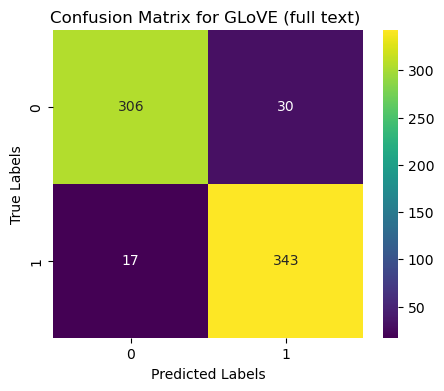

Accuracy: 0.9324712643678161
Recall: 0.9527777777777777
Precision: 0.9195710455764075
F1 Score: 0.9358799454297407


In [50]:

train_glove, test_glove = train_test_split(df[["full_text", "root_label"]], test_size=0.2)

# Convert labels to binary
train_labels = train_glove["root_label"].replace({'sports': 1, 'climate': 0}).astype(int)
test_labels = test_glove["root_label"].replace({'sports': 1, 'climate': 0}).astype(int)

# Process text data
train_glove = lemmatize(train_glove["full_text"].apply(clean))
test_glove = lemmatize(test_glove["full_text"].apply(clean))

# Load GloVe Embeddings
embeddings_dict = {}
with open("glove.6B.200d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

# Convert text to GloVe vectors
X_train_glove = [glove_conv(text, embeddings_dict) for text in train_glove]
X_test_glove = [glove_conv(text, embeddings_dict) for text in test_glove]

# Initialize and Train SVM Classifier
svm = SVC(C=10, kernel='linear', probability=True)
svm.fit(X_train_glove, train_labels)

# Evaluate the Classifier
predicted_labels = svm.predict(X_test_glove)
confusion_matrix = metrics.confusion_matrix(test_labels, predicted_labels)
accuracy = metrics.accuracy_score(test_labels, predicted_labels)
recall = metrics.recall_score(test_labels, predicted_labels)
precision = metrics.precision_score(test_labels, predicted_labels)
f1_score = metrics.f1_score(test_labels, predicted_labels)

# Print Evaluation Metrics
# confusion matrix plot
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for GLoVE (full text) ')
plt.show()
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1_score)


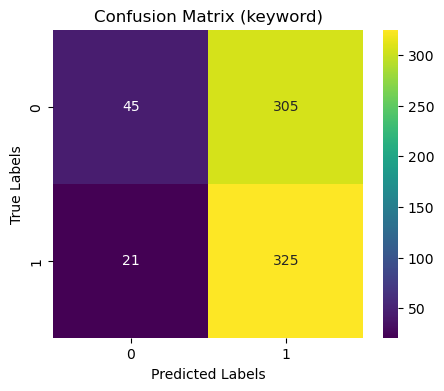

Accuracy: 0.5316091954022989
Recall: 0.9393063583815029
Precision: 0.5158730158730159
F1 Score: 0.6659836065573771


In [51]:


train_data, test_data = train_test_split(df[["keywords", "root_label"]], test_size=0.2)

# Convert labels to binary
train_labels = train_data["root_label"].replace({'sports': 1, 'climate': 0}).astype(int)
test_labels = test_data["root_label"].replace({'sports': 1, 'climate': 0}).astype(int)

# Process keyword data
train_keywords = lemmatize(train_data["keywords"].apply(clean))
test_keywords = lemmatize(test_data["keywords"].apply(clean))

# Load GloVe Embeddings
embeddings_dict = {}
with open("glove.6B.200d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

# Convert keywords to GloVe vectors
X_train_glove = [glove_conv(text, embeddings_dict) for text in train_keywords]
X_test_glove = [glove_conv(text, embeddings_dict) for text in test_keywords]

# Initialize and Train SVM Classifier
svm = SVC(C=10, kernel='linear', probability=True)
svm.fit(X_train_glove, train_labels)

# Evaluate the Classifier
predicted_labels = svm.predict(X_test_glove)
confusion_matrix = metrics.confusion_matrix(test_labels, predicted_labels)
accuracy = metrics.accuracy_score(test_labels, predicted_labels)
recall = metrics.recall_score(test_labels, predicted_labels)
precision = metrics.precision_score(test_labels, predicted_labels)
f1_score = metrics.f1_score(test_labels, predicted_labels)

# Print Evaluation Metrics
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='viridis')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (keyword)')
plt.show()
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1_score)


# Question 11

(a)
  - Featuring engineering process

     1.Spilt train and test data set by using train_test_split

     2.clean and lemmatize the text by apply corresponding function

     3.apply glove_conv to processes the representation of the text
   
     4.aggregating word vectors into a single vector by normalizing and averaging vectors
  - The function glove_conv read sentence from the input,breaks Them    into Words (Tokenization) and compare them with the dictionary(in this case 'glove.6B.200d.txt') ,If a word in the sentence is found in the GloVe dictionary, it is represented by its corresponding embedding (a 300-dimensional vector)
  
(b)We selected Linear SVM model with γ=10 for better runtime efficiency 

In [52]:
# functions for more effectively different dimension GLoVE embedding 
def load_glove_embeddings(dimension):
    embeddings_dict = {}
    filename = f"glove.6B.{dimension}d.txt"
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict

def glove_conv(text, embeddings_dict):
    # Tokenize the text
    word_list = word_tokenize(text)
    # Retrieve embeddings for each token
    embeddings = [embeddings_dict.get(word) for word in word_list if word in embeddings_dict]
    if not embeddings:
        return np.zeros(len(list(embeddings_dict.values())[0]))  # Return zero vector if no words found
    return np.mean(embeddings, axis=0)

def train_and_evaluate(embeddings_dict):
    # Data Preprocessing
    train_glove, test_glove = train_test_split(df[["full_text", "root_label"]], test_size=0.2)
    train_glove['full_text'] = train_glove['full_text'].apply(clean).apply(lemmatize)
    test_glove['full_text'] = test_glove['full_text'].apply(clean).apply(lemmatize)

    # Convert labels to binary
    train_labels = train_glove["root_label"].replace({'sports': 1, 'climate': 0}).astype(int)
    test_labels = test_glove["root_label"].replace({'sports': 1, 'climate': 0}).astype(int)

    # Convert text to GloVe vectors
    X_train_glove = [glove_conv(text, embeddings_dict) for text in train_glove['full_text']]
    X_test_glove = [glove_conv(text, embeddings_dict) for text in test_glove['full_text']]

    # Train SVM Classifier
    svm = SVC(C=10, kernel='linear', probability=True)
    svm.fit(X_train_glove, train_labels)

    # Evaluate the classifier
    predicted_labels = svm.predict(X_test_glove)
    accuracy = metrics.accuracy_score(test_labels, predicted_labels)
    return accuracy

In [53]:

# Load GloVe Embeddings of different dimensions
glove_dimensions = [50, 100, 200, 300]
accuracies = {}

for dim in glove_dimensions:
    embeddings = load_glove_embeddings(dim)
    accuracy = train_and_evaluate(embeddings)
    accuracies[dim] = accuracy
    print(f"Accuracy with GloVe {dim}d: {accuracy}")



Accuracy with GloVe 50d: 0.9454022988505747
Accuracy with GloVe 100d: 0.9540229885057471
Accuracy with GloVe 200d: 0.9497126436781609
Accuracy with GloVe 300d: 0.9683908045977011


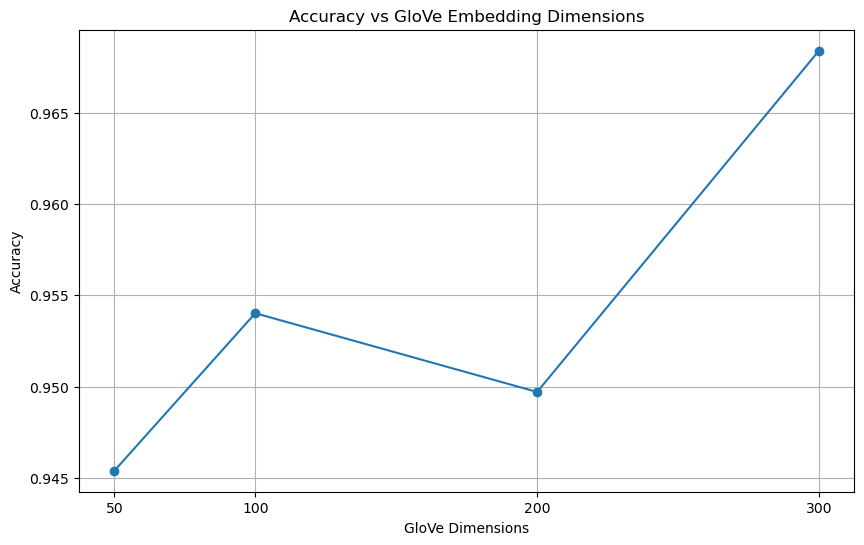

In [54]:
# Plotting the relationship between GloVe dimensions and accuracy
plt.figure(figsize=(10, 6))
plt.plot(glove_dimensions, [accuracies[dim] for dim in glove_dimensions], marker='o')
plt.xlabel('GloVe Dimensions')
plt.ylabel('Accuracy')
plt.title('Accuracy vs GloVe Embedding Dimensions')
plt.xticks(glove_dimensions)
plt.grid(True)
plt.show()
